In [1]:
# importaing the required libraries

import os
path = r"C:\Users\KAI\Coding\ThinkOnward_challenge\thinkOnward_TSClassification\data\building-instinct-starter-notebook\Starter notebook"
os.chdir(path)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils import (calculate_average_hourly_energy_consumption, train_model, get_pred, calculate_hierarchical_f1_score,
sample_submission_generator)

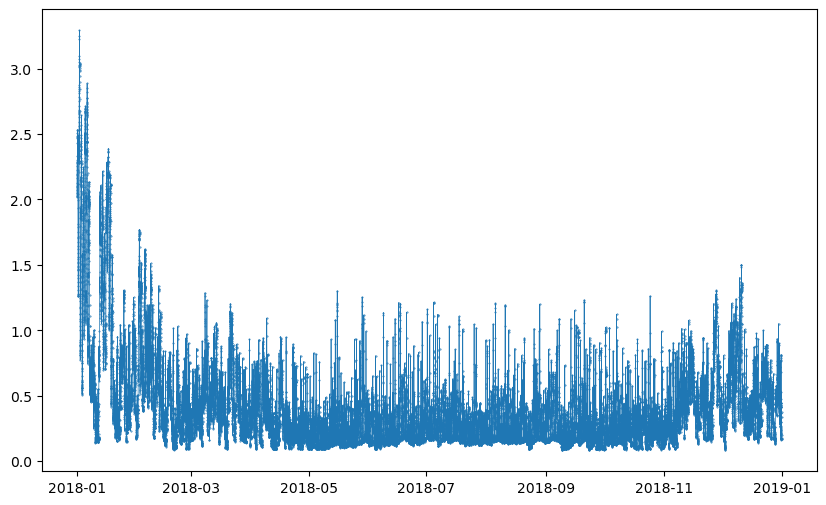

In [55]:
load_filepath_bldg = os.path.join(os.getcwd(),'building-instinct-train-data', '1.parquet') # path to a file in the train dataset
df_bldg = pd.read_parquet(load_filepath_bldg, engine='pyarrow')
df_bldg['timestamp'] = pd.to_datetime(df_bldg['timestamp'])
plt.figure(figsize=(10, 6))
plt.plot(df_bldg['timestamp'], df_bldg['out.electricity.total.energy_consumption'], linewidth=0.5, marker='o', markersize=0.4)
plt.show()

### Starter Notebook -> Average hourly consumption

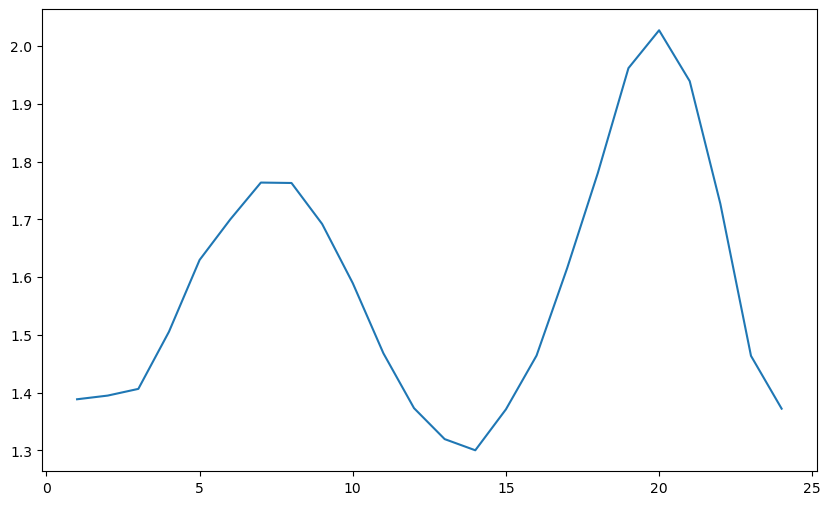

In [26]:
season_months_dict = {'year': [i for i in range(1,13)]}
# Extract month and hour from 'timestamp'
df_bldg['month'] = df_bldg['timestamp'].dt.month
df_bldg['hour'] = df_bldg['timestamp'].dt.hour

# Create a mapping from month to the corresponding season
month_to_season = {month: season for season, months_list in season_months_dict.items() for month in months_list}

# Assign a season to each row based on the month
df_bldg['season'] = df_bldg['month'].map(month_to_season)

# Calculate hourly average energy consumption for each row
df_bldg['hourly_avg_energy_consumption'] = 4 * df_bldg.groupby(['season', 'hour'])['out.electricity.total.energy_consumption'].transform('mean')

# Pivot the dataframe to create the desired output format
result_df_bldg = df_bldg.pivot_table(values='hourly_avg_energy_consumption', index='bldg_id', columns=['season', 'hour'])

# Reset the column names
result_df_bldg.columns = pd.MultiIndex.from_tuples([(season, hour+1) for season, months_list in season_months_dict.items() for hour in range(24)])
plt.figure(figsize=(10, 6))
plt.plot([int(i[1]) for i in result_df_bldg.columns], result_df_bldg.values[0])
plt.show()

### Average only over time slot of each hour -> hourly consumption per day

In [ ]:
 df_bldg['month'] = df_bldg['timestamp'].dt.month
df_bldg['hour'] = df_bldg['timestamp'].dt.hour
df_bldg['day_of_year'] = df_bldg['timestamp'].dt.day_of_year

# # Create a mapping from month to the corresponding season
# month_to_season = {month: season for season, months_list in season_months_dict.items() for month in months_list}

# # Assign a season to each row based on the month
# df_bldg['season'] = df_bldg['month'].map(month_to_season)

# # Calculate hourly average energy consumption for each row
df_bldg['hourly_energy_consumption'] = df_bldg.groupby(['day_of_year', 'hour'])['out.electricity.total.energy_consumption'].transform('mean')
# display(df_bldg.head(48))

# result_df_bldg = df_bldg[['hourly_energy_consumption', 'day_of_year', 'hour']].copy()#.groupby(['day_of_year', 'hour']).mean()
# result_df_bldg.reset_index(drop=True, inplace=True)
# result_df_bldg['datetime'] = pd.to_datetime('2018') + pd.to_timedelta(result_df_bldg['day_of_year'] - 1, unit='D') + pd.to_timedelta(result_df_bldg['hour'], unit='H')
# result_df_bldg_grouped = result_df_bldg.groupby('datetime')['hourly_energy_consumption'].mean().reset_index()
# print(result_df_bldg_grouped)
# # Pivot the dataframe to create the desired output format
result_df_bldg = df_bldg.pivot_table(values='hourly_energy_consumption', index='bldg_id', columns=['day_of_year', 'hour'])
display(result_df_bldg)
# # Reset the column names
# result_df_bldg.columns = pd.MultiIndex.from_tuples([(season, hour+1) for season, months_list in season_months_dict.items() for hour in range(24)])
# plt.figure(figsize=(10, 6))
# plt.plot(result_df_bldg_grouped['datetime'], result_df_bldg_grouped['hourly_energy_consumption'], linewidth=0.5, marker='o', markersize=0.4)
# plt.show()

In [3]:
folder_path = os.path.join(os.getcwd(),'building-instinct-train-data')# folder path for the train dataset
result_dfs = []
for file_name in tqdm(os.listdir(folder_path)):
        if file_name.endswith(".parquet"):
            # Extract the bldg_id from the file name
            bldg_id = int(file_name.split('.')[0])

            # Construct the full file path
            file_path = os.path.join(folder_path, file_name)

            # Read the original parquet file
            df_bldg = pd.read_parquet(file_path)

            # Convert 'timestamp' column to datetime
            df_bldg['timestamp'] = pd.to_datetime(df_bldg['timestamp'])
            # Extract month and hour from 'timestamp'
            df_bldg['hour'] = df_bldg['timestamp'].dt.hour
            df_bldg['day_of_year'] = df_bldg['timestamp'].dt.day_of_year

            df_bldg['hourly_energy_consumption'] = df_bldg.groupby(['day_of_year', 'hour'])['out.electricity.total.energy_consumption'].transform('mean')

            result_df_bldg = df_bldg.pivot_table(values='hourly_energy_consumption', index='bldg_id', columns=['day_of_year', 'hour'])
            result_df_bldg['bldg_id'] = bldg_id
            result_df_bldg.set_index('bldg_id', inplace=True)

            # Append the result_df to the list
            result_dfs.append(result_df_bldg)

df_hourly = pd.concat(result_dfs, ignore_index=False)
print(df_hourly)

100%|██████████| 7200/7200 [07:00<00:00, 17.12it/s]


day_of_year       1                                                           \
hour               0          1          2          3          4          5    
bldg_id                                                                        
1            1.738500   2.041750   2.145750   2.266250   2.462500   2.452250   
10           0.189250   0.324250   0.380750   0.403500   0.421750   0.431000   
100          0.189750   0.145750   0.123750   0.118500   0.100250   0.093500   
1000         0.389250   0.478750   0.122250   0.209250   0.110250   0.120000   
1001         0.072000   0.057000   0.060000   0.059250   0.059000   0.116250   
...               ...        ...        ...        ...        ...        ...   
995          3.559037   3.976103   4.473364   2.692369   2.035656   2.427451   
996          5.154681  12.673273  15.691518  17.280308  18.233289  18.600425   
997          0.240750   0.272500   0.322000   0.286500   0.260000   0.256500   
998          0.498750   0.761250   1.216

In [4]:
df_hourly.sort_index(inplace=True)
print(df_hourly)
load_filepath_labels = os.path.join(os.getcwd(),'building-instinct-train-label', 'train_label.parquet')#path to the train label file
df_targets = pd.read_parquet(load_filepath_labels, engine='pyarrow')
print(df_targets)

day_of_year        1                                                           \
hour                0          1          2          3          4          5    
bldg_id                                                                         
1             1.738500   2.041750   2.145750   2.266250   2.462500   2.452250   
2             0.943750   1.249750   1.172000   1.195500   0.628250   0.626250   
3             7.973651   8.935981   7.670330   8.966064  10.389094  10.610956   
4             0.234750   0.310500   0.337250   0.390250   0.435000   0.558250   
5             1.020613   1.040589   1.048086   1.049640   1.050228   1.051597   
...                ...        ...        ...        ...        ...        ...   
7196          0.518000   0.707500   0.500000   0.299500   0.219000   0.846250   
7197          1.468500   1.624000   0.605250   0.513000   0.782000   0.962750   
7198          7.016759  13.098101  15.785666  16.445550  17.423690  20.337114   
7199          0.073250   0.0

In [5]:
# columns_com = df_targets.filter(like='_com').columns.tolist()
# print('\n Metadata columns for commercial buildings: \n',columns_com)

# columns_res = df_targets.filter(like='_res').columns.tolist()
# print('\n Metadata columns for residential buildings: \n',columns_res)
X_train, X_test, y_train, y_test = train_test_split(df_hourly, df_targets, test_size=0.2, random_state=42)
column_list = list(df_targets.columns)

classifier_list = train_model(X = X_train, y = y_train)
y_pred = get_pred(X = X_test, classifier_list = classifier_list, column_list = column_list)
# evaluation
F1, F1_dict = calculate_hierarchical_f1_score(y_test, y_pred, alpha=0.4, average = 'macro', F1_list = True)

df_f1_scores = pd.DataFrame(list(F1_dict.items()), columns=['column name', 'Macro F1-score'])

df_f1_scores.set_index('column name', inplace=True)

print(f'Hierarchical F1-score: {F1} \n')

print('Macro F1-scores for all the individual columns:\n')

df_f1_scores


 Metadata columns for commercial buildings: 
 ['in.comstock_building_type_group_com', 'in.heating_fuel_com', 'in.hvac_category_com', 'in.number_of_stories_com', 'in.ownership_type_com', 'in.vintage_com', 'in.wall_construction_type_com', 'in.tstat_clg_sp_f..f_com', 'in.tstat_htg_sp_f..f_com', 'in.weekday_opening_time..hr_com', 'in.weekday_operating_hours..hr_com']

 Metadata columns for residential buildings: 
 ['in.bedrooms_res', 'in.cooling_setpoint_res', 'in.heating_setpoint_res', 'in.geometry_building_type_recs_res', 'in.geometry_floor_area_res', 'in.geometry_foundation_type_res', 'in.geometry_wall_type_res', 'in.heating_fuel_res', 'in.income_res', 'in.roof_material_res', 'in.tenure_res', 'in.vacancy_status_res', 'in.vintage_res']
Hierarchical F1-score: 0.5406388320166617 

Macro F1-scores for all the individual columns:



,Macro F1-score
column name,
building_stock_type,0.995116
in.vacancy_status_res,0.964272
in.tenure_res,0.685794
in.comstock_building_type_group_com,0.550348
in.hvac_category_com,0.309905
in.bedrooms_res,0.264897
in.geometry_building_type_recs_res,0.263159
in.wall_construction_type_com,0.260154
in.heating_fuel_com,0.228351


In [7]:
bldg_id_list = [i for i in range(1,1441)]
df_sample = sample_submission_generator(bldg_id_list, df_targets, 'sample_submission_18_07.parquet')

print('The generated sample submission DataFrame that is saved as a .parquet file: \n')
df_sample

The generated sample submission DataFrame that is saved as a .parquet file: 



,building_stock_type,in.comstock_building_type_group_com,in.heating_fuel_com,in.hvac_category_com,in.number_of_stories_com,in.ownership_type_com,in.vintage_com,in.wall_construction_type_com,in.tstat_clg_sp_f..f_com,in.tstat_htg_sp_f..f_com,...,in.geometry_building_type_recs_res,in.geometry_floor_area_res,in.geometry_foundation_type_res,in.geometry_wall_type_res,in.heating_fuel_res,in.income_res,in.roof_material_res,in.tenure_res,in.vacancy_status_res,in.vintage_res
bldg_id,,,,,,,,,,,,,,,,,,,,,
1,commercial,Mercantile,Electricity,Small Packaged Unit,1,owner_occupied,1990 to 1999,SteelFramed,74,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,residential,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Multi-Family with 5+ Units,2500-2999,Heated Basement,Brick,Electricity,30000-34999,Composition Shingles,Owner,Occupied,1950s
3,commercial,Office,NaturalGas,Multizone CAV/VAV,1,owner_occupied,1970 to 1979,SteelFramed,999,69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,residential,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Single-Family Detached,500-749,Unvented Crawlspace,Wood Frame,Electricity,50000-59999,"Asphalt Shingles, Medium",Renter,Vacant,1950s
5,commercial,Mercantile,FuelOil,Zone-by-Zone,3,owner_occupied,Before 1946,SteelFramed,72,999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,commercial,Warehouse and Storage,NaturalGas,Small Packaged Unit,1,local,1990 to 1999,WoodFramed,999,68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1437,residential,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Single-Family Attached,1000-1499,Heated Basement,Wood Frame,Electricity,120000-139999,"Asphalt Shingles, Medium",Renter,Occupied,1980s
1438,residential,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Single-Family Detached,1000-1499,Vented Crawlspace,Wood Frame,Electricity,40000-44999,Composition Shingles,Renter,Occupied,1950s


#### Submission time

In [8]:
# use full train set for training
df_hourly.sort_index(inplace=True)
load_filepath_labels = os.path.join(os.getcwd(),'building-instinct-train-label', 'train_label.parquet')#path to the train label file
df_targets = pd.read_parquet(load_filepath_labels, engine='pyarrow')
column_list = list(df_targets.columns)
classifier_list = train_model(X = df_hourly, y = df_targets)

In [9]:
folder_path = os.path.join(os.getcwd(),'building-instinct-test-data')# folder path for the train dataset
result_dfs = []
for file_name in tqdm(os.listdir(folder_path)):
        if file_name.endswith(".parquet"):
            # Extract the bldg_id from the file name
            bldg_id = int(file_name.split('.')[0])

            # Construct the full file path
            file_path = os.path.join(folder_path, file_name)

            # Read the original parquet file
            df_bldg = pd.read_parquet(file_path)

            # Convert 'timestamp' column to datetime
            df_bldg['timestamp'] = pd.to_datetime(df_bldg['timestamp'])
            # Extract month and hour from 'timestamp'
            df_bldg['hour'] = df_bldg['timestamp'].dt.hour
            df_bldg['day_of_year'] = df_bldg['timestamp'].dt.day_of_year

            df_bldg['hourly_energy_consumption'] = df_bldg.groupby(['day_of_year', 'hour'])['out.electricity.total.energy_consumption'].transform('mean')

            result_df_bldg = df_bldg.pivot_table(values='hourly_energy_consumption', index='bldg_id', columns=['day_of_year', 'hour'])
            result_df_bldg['bldg_id'] = bldg_id
            result_df_bldg.set_index('bldg_id', inplace=True)

            # Append the result_df to the list
            result_dfs.append(result_df_bldg)

X_test = pd.concat(result_dfs, ignore_index=False)
X_test.sort_index(inplace=True)

100%|██████████| 1450/1450 [01:29<00:00, 16.15it/s]


In [10]:
y_pred = get_pred(X = X_test, classifier_list = classifier_list, column_list = column_list)

bldg_id_list = [i for i in range(1,1441)]
df_sample = sample_submission_generator(bldg_id_list, y_pred, 'sample_submission_18_07_02.parquet')